# Bayesian Statistics Project
By: Georges SARR - Lasme Ephrem ESSOH - Hamdi BEL HADJ HASSINE 

In [1]:
# Install/Import packages
! pip install cvxpy

In [1]:
import numpy as np
import cvxpy as cp
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.linalg import sqrtm
from scipy.stats import beta as beta_distribution
from numpy.random import gamma as gamma_distribution
from numpy.random import uniform as uniform_distribution
from numpy.random import multivariate_normal
import pandas as pd
from IPython.display import clear_output
import scipy
from joblib import Parallel, delayed

## Data Generation

We try to replicate the paper's results so we generate the same example datasets as the first 4 ones used in the paper.

In [2]:
def get(data,g, beg):
  '''
  # INPUT:         # data is a dictionary of key in ["X", "beta"] if key="X" then data should be the data of covariates
                     otherwise it should be an np.array of the parameter beta
                   # g is the number of the group to retrieve
                   # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                      beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.

  # OUTPUT:        # Returns the gth group of X/beta , example get({"X":np.array([...])},0,beg) retrievs the first group of X
  '''
  assert type(data)==dict
  assert beg[0]==0 and len(beg)>=2
  assert 0<=g<len(beg)
  if list(data.keys())[0]=="X":
    if g<len(beg)-1:
      return data["X"][:, beg[g]:beg[g+1]]
    else:
      return data["X"][:, beg[g]:]
  elif list(data.keys())[0]=="beta":
    if g<len(beg)-1:
      return data["beta"][beg[g]:beg[g+1]]
    else:
      return data["beta"][beg[g]:]

def lgroup(g,beg, nb_covariates):
  '''
  # INPUT:       # g is the number of the group to retrieve
                 # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                      beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.
                 # nb_covariates is the total number of features/covariates

  # OUTPUT:      # gives the length of the gth group
  '''
  assert beg[0]==0 and len(beg)>=2
  assert 0<=g<len(beg)
  if g<len(beg)-1:
    return beg[g+1]-beg[g]
  else:
    return nb_covariates-beg[g]

In [49]:
### examples
nb_sims=50 # number of replications for each example

# parametrizing the examples
example={1: {"beta": np.array([0.3,-1,0,0.5,0.01]+[0]*5+[0.8]*5+[0]*5), # true parameter
             "n":100,  # number of observations
             "p":20,   # number of covariates
             "sigma":3, # the standard deviation of the residuals
             "beg":list(range(0,20,5)), # the indices of the beginning of the groups (the first group starts at index 0 and ends at index 4, 
                                        # the next one starts at index 5 and ends at index 9, etc)
             "sim":dict() # will store the simulations of X and Y                                       
             },
         
         2: {"beta": np.array([1,2,3,4,5]+[0]*5+[0.1,0.2,0.3,0.4,0.5]+[0]*(13*5)),
             "n": 60,
             "p": 80,
             "sigma": 2,
             "beg": [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75],
             "sim": dict()},
         
         3: {"beta": np.array([0]*10+[2]*10+[0]*10+[2]*10),
             "n": 100,
             "p": 40,
             "sigma": 2,
             "beg": [0,10,20,30],
             "sim": dict()
             },
         
         4: {"beta": np.array([0]*10+[2]*5+[0]*5+[0]*10+[2]*5+[0]*5),
             "n": 100,
             "p": 40,
             "sigma": 2,
             "beg": [0,10,15,20,30,35],
             "sim": dict()
            }
        }

# simulating the examples

## example 1
for k in range(nb_sims):
  epsilon=np.random.multivariate_normal([0]*example[1]["n"], (example[1]["sigma"]**2)*np.eye(example[1]["n"]))
  mean=[0]*example[1]["p"]
  cov=0.5*( np.ones((example[1]["p"],example[1]["p"])) + np.eye(example[1]["p"]) )
  example[1]['sim'][k]={"X":np.random.multivariate_normal(mean, cov, example[1]["n"])}
  example[1]['sim'][k]["Y"]=example[1]['sim'][k]["X"]@example[1]['beta']+epsilon 

## examples 2, 3 and 4
def simulate(exple, number):
  '''
  Simulating example 2, 3, and 4
  '''
  for k in range(nb_sims):
    n,p, sigma=exple[number]["n"],exple[number]["p"],exple[number]["sigma"]
    epsilon=np.random.multivariate_normal([0]*n, (sigma**2)*np.eye(n))
    beg=exple[number]["beg"]
    X=[]
    for g in range(len(beg)):
      m_g=lgroup(g,beg, p)
      z_g = np.random.multivariate_normal([0]*n, np.eye(n))
      z_gs = np.stack([z_g for _ in range(m_g)])
      z_gjs = np.random.multivariate_normal([0]*n, np.eye(n), m_g)
      X_g = z_gs + z_gjs
      X_g = X_g.T
      X.append(X_g)
    X=np.concatenate(X, axis=1)
    exple[number]['sim'][k] = {"X":X}
    exple[number]['sim'][k]["Y"] = X@exple[number]['beta']+epsilon

for number in [2,3,4]:
  simulate(example, number)

beta_star=example[1]["beta"]
X=example[1]["sim"][0]["X"]
Y=example[1]["sim"][0]["Y"]

# Group Lasso

The objective is to solve (1)
\begin{equation} 
\min_{\beta \in \mathbb{R}^p} || Y - X \beta ||_2^2 + \lambda \sum_{g=1}^G||\beta_g||_2
\end{equation}

where $\beta=(\beta_1',...,\beta_G')' \in \mathbb{R}^p$ and $\beta_g \in \mathbb{R}^{m_g}$ such that $\sum_{g=1}^G m_g = p$

In [171]:
def train_test_split(X,Y,train_threshold=0.8):
  '''
  ## INPUT:       # X the covariates data
                  # Y the labels data
                  # train_threshold is the percentage of the data that make up the training data
  
  ## OUTPUT:      # The training and validation sets
  '''
  n=X.shape[0]
  perm_ids=np.random.permutation(n)
  train_ids=perm_ids[:int(n*train_threshold)] 
  val_ids=perm_ids[int(n*train_threshold):]
  Xtrain, Xval = X[train_ids], X[val_ids]
  Ytrain, Yval = Y[train_ids], Y[val_ids]

  return Xtrain,Xval,Ytrain,Yval



def run_group_lasso(Xtrain, Ytrain, Xval, Yval, lamb, beg, val_mse, solver):
  '''
  ## INPUT:        # Xtrain is the training data covariates
                   # Ytrain is the training data labels
                   # Xval is the validation data covariates
                   # Yval is the validation data labels
                   # lamb is the Group Lasso penalty coefficient
                   # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                      beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.
                   # val_mse is a list for validation mean squared errors
                   # solver is the solver used to solve the optimization problem

  ## OUTPUT:       # The validation mse updated and one solution (= to None if the solver did not find a solution)
  '''
  p=Xtrain.shape[1]
  beta=cp.Variable(p)
  if len(beg)>1:
    cost = sum([cp.sum_squares(Ytrain-Xtrain@beta),
                lamb*sum([cp.norm(beta[beg[i]:beg[i+1]],2) for i in range(len(beg)-1)]),
                lamb*cp.norm(beta[beg[-1]:],2)
              ])
  if len(beg)==1:
    # ridge penalty case
    cost = sum([cp.sum_squares(Ytrain-Xtrain@beta), lamb*cp.norm(beta,2)])
  prob = cp.Problem(cp.Minimize(cost))
  try:
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      # solve the problem
      prob.solve(solver=solver)
      solution=beta.value
  except: solution=None # No solution found
  
  # updating the list of validation mse if there is a validation set
  if solution is not None and len(Yval)>0 and len(Xval)>0:
    val_mse.append(np.linalg.norm(Yval-Xval@solution,2)**2/len(Yval))

  return val_mse, solution


def optimal_group_lasso(X,Y,lambdas, beg,train_threshold=0.8, nb_runs=50, solvers=["ECOS"]):
  '''
  ## INPUT:         # X is the matrix of covariates
                    # Y is the vector of labels
                    # lambdas is a list of Group Lasso penalty coefficient
                    # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                      beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.
                    # train_threshold designates the proportion of data X,Y used for training
                    # nb_runs is the number of times the solvers are run for each lambda in lambdas
                    # solvers is a list of solvers used to solve the group lasso optimization problem using cvxpy package
  
  ## OUTPUT:        # returns the "optimal" Group Lasso penalty coeffient for each cvxpy solver along with the validation sets mean squared errors for 
                      each solver and lambda
  '''
  if beg[0]!=0:
    raise ValueError ("beg should be a list like object with 0 as the first element")

  mse=dict()
  opt_lambda=dict()
  n,p=X.shape

  for solver in solvers:
    mse[solver]=dict()
    opt_lambda[solver]=dict()
    print(solver ,":")
    for lamb in tqdm(lambdas):
      val_mse=[]
      # running the optimization nrun times after permuting the data each time
      for _ in range(nb_runs):
        Xtrain,Xval,Ytrain,Yval=train_test_split(X,Y,train_threshold=0.8)
        # solving the optimization problem
        val_mse, _ = run_group_lasso(Xtrain, Ytrain, Xval, Yval, lamb, beg, val_mse, solver)
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mse[solver][lamb]=val_mse
        # metric = standard deviation adjusted mean mse
        opt_lambda[solver][lamb]=np.mean(val_mse)+np.std(val_mse) 

    # optimal lambda and metric for a given solver
    opt_lambda[solver]=sorted(opt_lambda[solver].items(), key=lambda item: item[1], reverse=False)[0]

  # optimal solver: each solver is associated to its optimal adjusted mean mse
  solver_opt_metric = {solver: opt_lambda[solver][1] for solver in opt_lambda}
  opt_solver = sorted(solver_opt_metric.items(), key=lambda item: item[1], reverse=False)[0][0]

  return mse, {opt_solver: opt_lambda[opt_solver][0]}


def plot_lambda_vs_mse(lambdas, mse, nb_runs, solver='ECOS'):
  plt.figure(figsize=(20,10))
  a=[l for l in lambdas for _ in range(len(mse[solver][l]))]
  b=np.concatenate([mse[solver][l] for l in lambdas], axis=0)
  sb.boxplot(x=a, y=b)
  plt.xlabel("$\lambda$")
  plt.ylabel("MSE")
  plt.title(f"Mean Squared Error on the validation sets with {nb_runs} runs using solver {solver}" )

In [172]:
lambdas=[1e-6, 1e-4, 1e-2, 1, 10, 100, 1000, 1e4, 1e5, 1e6]
nb_runs = 100      
train_threshold=0.6
solvers=["CVXOPT", "ECOS"]
beg=example[1]["beg"]

mse, opt_lambda=optimal_group_lasso(X, Y, lambdas, beg, train_threshold=train_threshold, nb_runs=nb_runs, solvers=solvers)

CVXOPT :


100%|██████████| 10/10 [00:12<00:00,  1.23s/it]


ECOS :


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


In [173]:
opt_lambda

{'CVXOPT': 10}

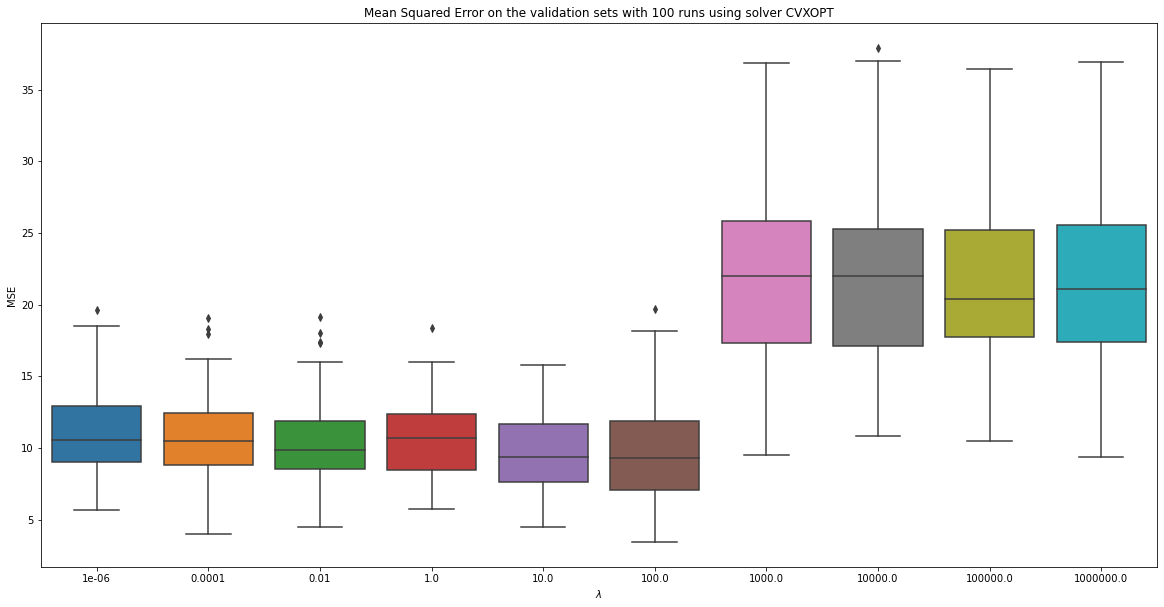

In [174]:
plot_lambda_vs_mse(lambdas, mse, nb_runs, solver=list(opt_lambda.keys())[0])

Solving the problem with the optimal $\lambda$

In [175]:
lambda_star=list(opt_lambda.values())[0]  # optimal lambda
eps=1e-6 # represents the tolerance to agree on equality of two float numbers

Xtrain,Xval,Ytrain,Yval=train_test_split(X,Y,train_threshold=0.8)
_, solution = run_group_lasso(X, Y, [], [], lambda_star, beg, [], list(opt_lambda.keys())[0])

if solution is not None:
    # True Positive Rate = proportion of non-zero coefficients correctly detected 
    TP=np.where((abs(beta_star)>eps) & (abs(solution)>eps))[0]
    # False positives: null coefficients that were estimated as non-zero
    FP=np.where((abs(beta_star)<eps) & (abs(solution)>eps))[0]
    # true zeros are the coordinates of zeros in the true solution
    true_zeros=np.where(beta_star==0)[0]
    # true non zeros are the non zeros coordinates of the true solution
    true_non_zeros=np.where(beta_star!=0)[0] 
    TPR=len(TP)/len(true_non_zeros)
    # FPR=FP/Negatives
    FPR=len(FP)/len(true_zeros)

    print(f"TPR={round(TPR,2)} , FPR={round(FPR,2)}")

TPR=1.0 , FPR=1.0


We can plot some predictions and true Y values for sanity check

In [163]:
X=example[1]["sim"][0]["X"]
Y=example[1]["sim"][0]["Y"]
Xtrain,Xval,Ytrain,Yval=train_test_split(X,Y,train_threshold=0.8)
val_mse = []
beg=example[1]["beg"]
beta_star=example[1]["beta"]
lamb = 100
solver = "ECOS"
p=Xtrain.shape[1]
beta=cp.Variable(p)
lamb = 100

cost = sum([cp.sum_squares(Ytrain-Xtrain@beta),
            lamb*sum([cp.norm(beta[beg[i]:beg[i+1]],2) for i in range(len(beg)-1)]),
            lamb*cp.norm(beta[beg[-1]:],2)])
prob = cp.Problem(cp.Minimize(cost))

prob.solve(solver=solver)
solution=beta.value

In [164]:
# SSE for the true beta (training data)
sum([np.linalg.norm(Ytrain-Xtrain@beta_star,2)**2])

672.5856888274578

In [165]:
# SSE for beta_hat (training data)
sum([np.linalg.norm(Ytrain-Xtrain@solution,2)**2])

663.8671220358722

In [170]:
# SSE for the true beta (testing data)
sum([np.linalg.norm(Yval-Xval@beta_star,2)**2])/len(Yval)

12.336773973703751

In [169]:
# SSE for beta_hat (testing data)
sum([np.linalg.norm(Yval-Xval@solution,2)**2])/len(Yval)

12.313807026177546

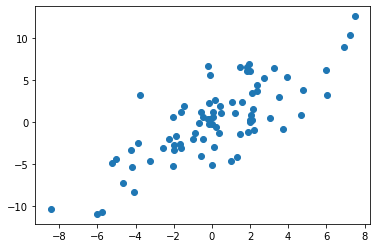

In [168]:
plt.scatter(Xtrain@solution, Ytrain)

Now let us do the whole process for all the simulations

In [179]:
def tpr_fpr_group_lasso_one_simulation(exple, sim_number, lambdas, train_threshold, solvers, eps=1e-6):
    '''
    ## INPUT:       # exple is a given example made of simulations
                  # lambdas is a list of Group Lasso penalty coefficient
                  # train_threshold designates the proportion of data X,Y used for training
                  # solvers is a list of solvers used to solve the group lasso optimization problem using cvxpy package
                  # eps is the tolerance to agree on equality on two float numbers

    ## OUTPUT:      # The True Positive and False Positive Rates
    '''
    # the data
    beg=exple["beg"]
    beta_star=exple["beta"]
    X=exple["sim"][sim_number]["X"]
    Y=exple["sim"][sim_number]["Y"]
    Xtrain,Xval,Ytrain,Yval=train_test_split(X,Y,train_threshold=train_threshold)

    # fine tuning lambda
    mse, opt_lambda=optimal_group_lasso(Xtrain, Ytrain, lambdas, beg, train_threshold=train_threshold, nb_runs=nb_runs, solvers=solvers)
    opt_solver, lambda_star = list(opt_lambda.items())[0]

    # solving with the optimal lambda, on the whole dataset (without validating)
    MSE, solution = run_group_lasso(Xtrain, Ytrain, Xval, Yval, lambda_star, beg, [], opt_solver)

    TPR,FPR = np.nan, np.nan
    if solution is not None:
        # True Positive Rate = proportion of non-zero coefficients correctly detected 
        TP=np.where((abs(beta_star)>eps) & (abs(solution)>eps))[0]
        # False positives: null coefficients that were estimated as non-zero
        FP=np.where((abs(beta_star)<eps) & (abs(solution)>eps))[0]
        # true zeros are the coordinates of zeros in the true solution
        true_zeros=np.where(beta_star==0)[0]
        # true non zeros are the non zeros coordinates of the true solution
        true_non_zeros=np.where(beta_star!=0)[0] 
        TPR=len(TP)/len(true_non_zeros)
        # FPR=FP/Negatives
        FPR=len(FP)/len(true_zeros)
    return((TPR,FPR,MSE[-1]))

In [180]:
lambdas=[1e-2, 1, 10, 100, 1000, 1e4]
nb_runs = 50
train_threshold=0.6
solvers=["CVXOPT", "ECOS"]

results_tpr_fpr_mse = []#pd.DataFrame(columns=["Mean TPR", "STD TPR" ,"Mean FPR", "STD FPR"])
for number in example:
    print(f"Example {number}")
    exple=example[number]
    nb_sims=len(exple["sim"])
    results = Parallel(n_jobs=10)(delayed(tpr_fpr_group_lasso_one_simulation)
        (exple, sim_number, lambdas, train_threshold, solvers)
        for sim_number in range(nb_sims))
    TPRs = [x[0] for x in results if x!=np.nan]
    FPRs = [x[1] for x in results if x!=np.nan]
    MSEs = [x[2] for x in results if x!=np.nan]
    results_tpr_fpr_mse.append([np.mean(TPRs), np.std(TPRs), np.mean(FPRs), np.std(FPRs), np.median(MSEs), np.std(MSEs)])

Example 1
Example 2
Example 3
Example 4


In [181]:
for number in example:
    results=results_tpr_fpr_mse[number-1]
    print(f"""Example {number}:\n
    Mean TPR={results[0]}, STD TPR={results[1]}\n
    Mean FPR={results[2]}, STD FPR={results[3]}\n
    Median MSE={results[4]}, STD MSE={results[5]}\n""")

Example 1:

    Mean TPR=0.9022222222222223, STD TPR=0.1841094682418487

    Mean FPR=0.5054545454545455, STD FPR=0.4013036607099087

    Median MSE=10.224343533226822, STD MSE=2.489460225131496

Example 2:

    Mean TPR=1.0, STD TPR=0.0

    Mean FPR=0.4217142857142857, STD FPR=0.3534002760356036

    Median MSE=6.552892470753012, STD MSE=2.222006791932855

Example 3:

    Mean TPR=1.0, STD TPR=0.0

    Mean FPR=0.55, STD FPR=0.33734255586866

    Median MSE=6.002643300534867, STD MSE=1.3112246487714037

Example 4:

    Mean TPR=1.0, STD TPR=0.0

    Mean FPR=0.5473333333333333, STD FPR=0.20397058611476315

    Median MSE=4.8696089502278435, STD MSE=1.3494361006521038



# Sparse Group Lasso

Solving 

\begin{equation}
\min_{\beta \in \mathbb{R}^p} || Y - X \beta ||_2^2 + \lambda_1 ||\beta||_1 + \lambda_2 \sum_{g=1}^G||\beta_g||_2
\end{equation}

where $\beta=(\beta_1',...,\beta_G')' \in \mathbb{R}^p$ and $\beta_g \in \mathbb{R}^{m_g}$ such that $\sum_{g=1}^G m_g = p$

In [185]:
def run_sparse_group_lasso(Xtrain, Ytrain, Xval, Yval, lamb1, lamb2, beg, val_mse, solver):
  '''
  ## INPUT:        # Xtrain is the training data covariates
                   # Ytrain is the training data labels
                   # Xval is the validation data covariates
                   # Yval is the validation data labels
                   # lamb1  is the sparsity penalty coefficient (L_1 norm)
                   # lamb2  is the Group Lasso penalty coefficient (L_2 norm)
                   # lamb is the Group Lasso penalty coefficient
                   # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                      beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.
                   # val_mse is a list for validation mean squared errors
                   # solver is the solver used to solve the optimization problem

  ## OUTPUT:       # The validation mse updated and one solution (= to None if the solver did not find a solution)
  '''
  p=Xtrain.shape[1]
  beta=cp.Variable(p)
  if len(beg)>1:
    cost = sum([cp.sum_squares(Ytrain-Xtrain@beta), lamb1*cp.norm(beta,1),
                        lamb2*sum([cp.norm(beta[beg[i]:beg[i+1]],2) for i in range(len(beg)-1)]), 
                        lamb2*cp.norm(beta[beg[-1]:],2)
               ])
  if len(beg)==1:
    # generalised elastic net case
    cost = sum([cp.sum_squares(Ytrain-Xtrain@beta), lamb1*cp.norm(beta,1), lamb2*cp.norm(beta,2)])
  prob = cp.Problem(cp.Minimize(cost))
  try:
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      # solve the problem
      prob.solve(solver=solver)
      solution=beta.value
  except: solution=None # No solution found
  
  # updating the list of validation mse if there is a validation set
  if solution is not None and len(Yval)>0 and len(Xval)>0:
    val_mse.append(np.linalg.norm(Yval-Xval@solution,2)**2/len(Yval))

  return val_mse, solution

def optimal_sparse_group_lasso(X,Y,lambdas1, lambdas2, beg,train_threshold=0.6, nb_runs=50, solvers=["ECOS"]):
  '''
  ## INPUT:         # X is the matrix of covariates
                    # Y is the vector of labels
                    # lambdas1  is a list of sparsity penalty coefficient (L_1 norm)
                    # lambdas2  is a list of group penalty coefficient (L_2 norm)
                    # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                      beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.
                    # train_threshold designates the proportion of data X,Y used for training
                    # nb_runs is the number of times the solvers are run for each lambda in lambdas
                    # solvers is a list of solvers used to solve the group lasso optimization problem using cvxpy package
  
  ## OUTPUT:        # returns the "optimal" Group Lasso and Sparsity penalty coeffients for each cvxpy solver along with the validation sets mean squared errors for 
                      each solver and lambda1 and lambda2
  '''
  if beg[0]!=0:
    raise ValueError ("beg should be a list like object with 0 as the first element")

  mse=dict()
  opt_lambdas=dict()
  n,p=X.shape

  for solver in solvers:
    mse[solver]=dict()
    opt_lambdas[solver]=dict()
    print(solver ,":")
    for lamb1 in tqdm(lambdas1):
      for lamb2 in lambdas2:
        val_mse=[]
        # running the optimization nrun times after permuting the data each time
        for _ in range(nb_runs):
          Xtrain,Xval,Ytrain,Yval=train_test_split(X,Y,train_threshold=0.8)
          # solving the optimization problem
          val_mse, _ = run_sparse_group_lasso(Xtrain, Ytrain, Xval, Yval, lamb1, lamb2, beg, val_mse, solver)
        with warnings.catch_warnings():
          warnings.simplefilter("ignore")
          mse[solver][(lamb1,lamb2)]=val_mse
          # metric = standard deviation adjusted mean mse
          opt_lambdas[solver][(lamb1,lamb2)]=np.mean(val_mse)+np.std(val_mse)

    # optimal (lambda1, lambda2) and metric for a given solver
    opt_lambdas[solver]=sorted(opt_lambdas[solver].items(), key=lambda item: item[1], reverse=False)[0]

  # optimal solver = each solver is associated to its optimal adjusted mean mse
  solver_opt_metric = {solver: opt_lambdas[solver][1] for solver in opt_lambdas} 
  opt_solver = sorted(solver_opt_metric.items(), key=lambda item: item[1], reverse=False)[0][0]

  return mse, {opt_solver: opt_lambdas[opt_solver][0]}
 

In [188]:
def tpr_fpr_saprse_group_lasso_one_simulation(exple, sim_number, lambdas1, lambdas2, train_threshold, solvers, eps=1e-6):
    '''
    ## INPUT:     # exple is a given example made of simulations
                  # sim_number: number of the simulation
                  # lambdas1 is a list of of sparsity penalty coefficient (L_1 norm)
                  # lambdas2 is a list of Group Lasso penalty coefficient (L_2 norm)
                  # train_threshold designates the proportion of data X,Y used for training
                  # solvers is a list of solvers used to solve the group lasso optimization problem using cvxpy package
                  # eps is the tolerance to agree on equality on two float numbers


    ## OUTPUT:      # The True Positive and False Positive Rates
    '''
    # the data
    beg=exple["beg"]
    beta_star=exple["beta"]
    X=exple["sim"][sim_number]["X"]
    Y=exple["sim"][sim_number]["Y"]
    Xtrain,Xval,Ytrain,Yval=train_test_split(X,Y,train_threshold=train_threshold)

    # fine tuning lambda
    mse, opt_lambda=optimal_sparse_group_lasso(Xtrain, Ytrain, lambdas1, lambdas2,
                                               beg, train_threshold=train_threshold, nb_runs=nb_runs, solvers=solvers)
    opt_solver, (lambda_star1, lambda_star2) = list(opt_lambda.items())[0]

    # solving with the optimal lambda, on the whole dataset (without validating)
    MSE, solution = run_sparse_group_lasso(Xtrain, Ytrain, Xval, Yval, lambda_star1, lambda_star2, beg, [], opt_solver)

    TPR,FPR = np.nan, np.nan
    if solution is not None:
        # True Positive Rate = proportion of non-zero coefficients correctly detected 
        TP=np.where((abs(beta_star)>eps) & (abs(solution)>eps))[0]
        # False positives: null coefficients that were estimated as non-zero
        FP=np.where((abs(beta_star)<eps) & (abs(solution)>eps))[0]
        # true zeros are the coordinates of zeros in the true solution
        true_zeros=np.where(beta_star==0)[0]
        # true non zeros are the non zeros coordinates of the true solution
        true_non_zeros=np.where(beta_star!=0)[0] 
        TPR=len(TP)/len(true_non_zeros)
        # FPR=FP/Negatives
        FPR=len(FP)/len(true_zeros)
    return((TPR,FPR,MSE[-1]))

In [189]:
lambdas1=[1e-6, 1e-4, 1e-2, 1, 10, 100, 1000, 1e4, 1e5, 1e6]
lambdas2=[100]
nb_runs = 50
train_threshold=0.6
solvers=["ECOS"]

results_tpr_fpr_mse = []
for number in example:
    print(f"Example {number}")
    exple=example[number]
    nb_sims=len(exple["sim"])
    results = Parallel(n_jobs=10)(delayed(tpr_fpr_saprse_group_lasso_one_simulation)
        (exple, sim_number, lambdas1, lambdas2, train_threshold, solvers)
        for sim_number in range(nb_sims))
    TPRs = [x[0] for x in results if x!=np.nan]
    FPRs = [x[1] for x in results if x!=np.nan]
    MSEs = [x[2] for x in results if x!=np.nan]
    results_tpr_fpr_mse.append([np.mean(TPRs), np.std(TPRs), np.mean(FPRs), np.std(FPRs), np.median(MSEs), np.std(MSEs)])

Example 1
Example 2
Example 3
Example 4


In [190]:
for number in example:
    results=results_tpr_fpr_mse[number-1]
    print(f"""Example {number}:\n
    Mean TPR={results[0]}, STD TPR={results[1]}\n
    Mean FPR={results[2]}, STD FPR={results[3]}\n
    Median MSE={results[4]}, STD MSE={results[5]}\n""")

Example 1:

    Mean TPR=0.8955555555555554, STD TPR=0.18245242911205342

    Mean FPR=0.4218181818181818, STD FPR=0.3210313956995381

    Median MSE=9.455899039139013, STD MSE=3.234905118261159

Example 2:

    Mean TPR=0.986, STD TPR=0.07213875518748572

    Mean FPR=0.14657142857142857, STD FPR=0.09261771329679075

    Median MSE=6.040333839231346, STD MSE=2.1089836048330275

Example 3:

    Mean TPR=1.0, STD TPR=0.0

    Mean FPR=0.593, STD FPR=0.3331681257263366

    Median MSE=5.847779089221204, STD MSE=1.255514579810498

Example 4:

    Mean TPR=1.0, STD TPR=0.0

    Mean FPR=0.5026666666666667, STD FPR=0.2612652972661229

    Median MSE=5.20056361437472, STD MSE=1.3368226804532515



## Bayesian Group Lasso with Spike and Slab Prior (BGL-SS)
### First implementation
This was our first implementation of this model. Unfortunately it didn't return correct results and we couldn't find the problem, so we coded another implementation.

In [7]:
def get_except(data,g,beg):
  '''
  # INPUT:         # data is a dictionary of key in ["X", "beta"] if key="X" then data should be the data of covariates
                     otherwise it should be an np.array of the parameter beta
                   # g is the number of the group to retrieve
                   # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                      beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.

  # OUTPUT:        # Returns X except the gth group , example get(X,0,beg) retrieves all X except the first group
  '''
  assert type(data)==dict
  assert beg[0]==0 and len(beg)>=2
  assert 0<=g<len(beg)
  if list(data.keys())[0]=="X":
    if g==0:
      return data["X"][:,beg[g+1]:]
    elif g==len(beg)-1:
      return data["X"][:,:beg[g]]
    else:
      return np.concatenate([data["X"][:, :beg[g]], data["X"][:, beg[g+1]:]], axis=1)

  elif list(data.keys())[0]=="beta":
    if g==0:
      return data["beta"][beg[g+1]:]
    elif g==len(beg)-1:
      return data["beta"][:beg[g]]
    else:
      return np.concatenate([data["beta"][:beg[g]], data["beta"][beg[g+1]:]])


def Zgs_and_mgs(beta, beg, nb_covariates, eps=1e-6):
  '''
  # INPUT:      # beta is the parameter to estimate
                # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                      beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.
                # nb_covariates is the total number of features/covariates

  # OUTPUT:     # Returns Z_gs the indicators of the beta_g=0 and m_gs the lengths/dimensions of the beta_gs     
  '''
  Z_gs = []
  m_gs = []
  for g in range(len(beg)):
    m_g = lgroup(g,beg,nb_covariates)
    m_gs.append(m_g)
    beta_g = get({"beta":beta}, g, beg)
    Z_g = max((abs(beta_g)>eps)*1)
    Z_gs.append(Z_g)
  return np.array(Z_gs), np.array(m_gs)

#### Priors simulation

In [25]:
def BGLSSPriorSigmaSquared(alpha, gamma):
  '''
  # INPUT:      # alpha is the shape of the inverse gamma prior for sigma^2
                # gamma is the scale of the inverse gamma prior for sigma^2
  
  # OUTPUT:     # a realisation of Inverse Gamma(alpha, gamma)
  '''
  return scipy.stats.invgamma.rvs(alpha , scale = gamma) #1/gamma_distribution(shape=alpha, scale=1/gamma)


def BGLSSPriorTauSquared(lamb, beg, nb_covariates):
  '''
  # INPUT:      # lamb is the group lasso penalty coefficient
                # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                      beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.
                # nb_covariates is the total number of features/covariates

  # OUTPUT:     # realisations of the tau_g^2 s (tau_g squared)
  '''
  taus_squared=[]
  for g in range(len(beg)):
    m_g = lgroup(g,beg,nb_covariates)
    tau_g_squared = gamma_distribution(shape=(m_g+1)/2, scale=(lamb**2)/2)
    taus_squared.append(tau_g_squared) 
  return np.array(taus_squared)


def BGLSSPriorPi0(a,b):
  '''
  # INPUT:      # a and b are parameters of a beta distribution
  
  # OUTPUT:     # a realisation of Beta(a, b)
  '''
  
  return scipy.stats.beta.rvs(a, b) #beta_distribution.rvs(a=a, b=b)


def BGLSSPriorBeta(sigma_squared, taus_squared, pi0):
  '''
  # INPUT:      # sigma_squared is a parameter of the BGL SS model
                # taus_squared includes the different values of tau_g's^2 (taus squared)
                # pi0 is a parameter of the BGL SS model
  
  # OUPUT:      # realisations of the beta_gs
  '''
  beta_gs=[]
  for g in range(len(beg)):
    m_g=lgroup(g,beg,X.shape[1])
    zeros_g=np.array([0]*m_g)
    unif=uniform_distribution(0,1)
    if unif <= pi0:
      beta_g=zeros_g
    else:
      beta_g=multivariate_normal(zeros_g, sigma_squared * taus_squared[g] * np.eye(m_g))
    beta_gs.append(beta_g)
  return beta_gs

#### Posteriors parameters

In [26]:
def BGLSSsigma(g, X, beg, tau_squared):
  '''
  # INPUT:       # g is the number of the group to retrieve
                 # X is the covariates data
                 # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                      beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.
                 # tau_squared is a parameter of the BGL SS model
  
  # OUTPUT:      # Sigma_g (scaled covariance of the gaussian part of the posterior distribution of beta_g)
  '''
  # assert tau_squared>0
  X_g = get({"X":X},g,beg)
  m_g = lgroup(g,beg, X.shape[1])
  
  return  np.linalg.inv(X_g.T@X_g + (1/tau_squared)*np.eye(m_g))

def BGLSSmu(g, X, Y, beta, beg, tau_squared):
  '''
  # INPUT:       # g is the number of the group to retrieve
                 # X is the covariates data
                 # Y is the labels data
                 # beta is the parameter to estimate
                 # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                      beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.
                 # tau_squared is a parameter of the BGL SS model
  
  # OUTPUT:      # mu_g (expectation of the gaussian part of the posterior distribution of beta_g)
  '''
  X_g = get({"X":X},g,beg)
  X__g = get_except({"X":X},g,beg)
  beta__g = get_except({"beta":beta},g,beg)
  Sigma_g = BGLSSsigma(g, X, beg, tau_squared)
  return Sigma_g@X_g.T@(Y-X__g@beta__g)


def BGLSSPosteriorproba0(g, X, Y, beta, beg, tau_squared, pi0, sigma_squared):
  '''
  # INPUT:       # g is the number of the group to retrieve
                 # X is the covariates data
                 # Y is the labels data
                 # beta is the parameter to estimate
                 # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                      beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.
                 # tau_squared is a parameter of the BGL SS model
                 # pi0 is a parameter of the BGL SS model
                 # sigma_squared is a parameter of the BGL SS model
  
  # OUTPUT:      # the conditional posterior probability that beta_g=0
  '''
  m_g = lgroup(g,beg, X.shape[1])
  X_g = get({"X":X},g,beg)
  X__g = get_except({"X":X},g,beg)
  beta__g = get_except({"beta":beta},g,beg)
  Sigma_g = BGLSSsigma(g, X, beg, tau_squared)
  arg_exp= (1/(2*sigma_squared))*(np.linalg.norm(sqrtm(Sigma_g)@X_g.T@(Y-X__g@beta__g),2)**2)
  # we add a maximum value for the argument (arg_exp) in the exponential to avoid avoerflow problems
  denominator=pi0+(1-pi0)*((tau_squared)**(-m_g/2))*np.sqrt(np.linalg.det(Sigma_g))*np.exp((min(arg_exp,500)))
  # denominator=pi0+(1-pi0)*((tau_squared)**(-m_g/2))*np.sqrt(np.linalg.det(Sigma_g))*np.exp(arg_exp)

  return pi0/denominator


#### Posteriors simulation

In [27]:
def BGLSSPosteriorSigmaSquared(X,Y, beta, beg, taus_squared, alpha, gamma, eps):
  '''
  # INPUT:       # X is the covariates data
                 # Y is the labels data
                 # beta is the parameter to estimate
                 # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                      beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.
                 # taus_squared includes the different values of tau's^2 (taus squared)
                 # alpha is the shape of the inverse gamma prior for sigma^2
                 # gamma is the scale of the inverse gamma prior for sigma^2
                 # eps is the tolerance to agree on equality on two float numbers

  # OUTPUT:      # a posterior random variable for sigma^2 (sigma squared)
  '''
  n,p = X.shape

  Z_gs, m_gs = Zgs_and_mgs(beta, beg, p, eps=eps)

  D_tau = []
  for g in range(len(beg)):
    D_tau.extend([taus_squared[g]]*m_gs[g])
    
  D_tau = np.diag(D_tau)

  # parameters of the posterior inverse gamma
  shape= (1/2)*(n+Z_gs@m_gs) + alpha
  scale= (1/2)*( (Y-X@beta).T@(Y-X@beta) + beta.T@np.linalg.inv(D_tau)@beta ) + gamma
  
  return scipy.stats.invgamma.rvs(shape , scale = scale)#1/gamma_distribution(shape=shape, scale=1/scale) # not sure about this sampler, we want to sample from Inverse Gamma(shape, scale) ~ 1/Gamma(shape,1/scale) ?


def BGLSSPosteriorPi0(beta, beg, a, b, nb_covariates, eps):
  '''
  # INPUT:       # beta is the parameter to estimate
                 # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                      beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.
                 # a the first parameter of the Beta prior for pi0
                 # b the second parameter of the Beta prior for pi0
                 # nb_covariates is the total number of features/covariates
                 # eps is the tolerance to agree on equality on two float numbers


  # OUTPUT:      # a posterior random variable for pi0
  '''  
  Z_gs, m_gs = Zgs_and_mgs(beta, beg, nb_covariates, eps=eps)

  # parameters of the posterior gamma
  a_post = a + sum(Z_gs)
  b_post = b + sum(m_gs-Z_gs) 

  return scipy.stats.beta.rvs(a_post, b_post)#beta_distribution.rvs(a=a_post, b=b_post)


def BGLSSPosteriorTauSquared(beta, beg, lamb, sigma_squared, nb_covariates, n_tau_samples, eps):
  '''
  # INPUT:       # beta is the parameter to estimate
                 # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                      beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.
                 # lamb is the group lasso penalty coefficient
                 # sigma_squared is a parameter of the BGL SS model
                 # nb_covariates is the total number of features/covariates
                 # n_tau_samples is the number of samples for each tau_g^2
                 # eps is the tolerance to agree on equality on two float numbers


  # OUTPUT:      # a posterior random variable for the tau_g^2 (tau_g squared), many times
  '''
  assert n_tau_samples>=1
  Z_gs, m_gs=Zgs_and_mgs(beta, beg, nb_covariates, eps)
  taus_squared = []
  for g in range(len(beg)):
    beta_g = get({"beta":beta}, g, beg)
    if Z_gs[g]==1:
      # shape=lamb*np.sqrt(sigma_squared)/np.linalg.norm(beta_g,2) 
      # scale=lamb**2
      shape=3/2 
      scale=lamb**2/2 + np.linalg.norm(beta_g,2)/(2*sigma_squared**2) 
      tau_squared = gamma_distribution(shape=shape, scale=1/scale, size=n_tau_samples)
    elif Z_gs[g]==0:
      # shape=(m_gs[g]+1)/2
      # scale=lamb**2/2
      shape=(m_gs[g]+1)/2 + 2
      scale=lamb**2/2      
      tau_squared = gamma_distribution(shape=shape, scale=1/scale, size=n_tau_samples)
    taus_squared.append(tau_squared)
  
  if n_tau_samples==1: return np.array(taus_squared).flatten() #.reshape(1,-1)[0]
  return np.array(taus_squared) # each column represents a realization of the vector of the taug_s


def BGLSSPosteriorBeta(X,Y, beta, beg, taus_squared, sigma_squared, pi0):
  '''
  # INPUT:      # X is the covariates data
                # Y is the labels data
                # beta is the parameter to estimate
                # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                    beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.
                # taus_squared includes the different values of tau's^2 (taus squared)
                # sigma_squared is a parameter of the BGL SS model
  
  # OUTPUT:     # The posterior beta_gs
  '''
  beta_gs=[]
  for g in range(len(beg)):
    tau_squared=taus_squared[g]
    post0=BGLSSPosteriorproba0(g, X, Y, beta, beg, tau_squared, pi0, sigma_squared)
    mu_g=BGLSSmu(g, X, Y, beta, beg, tau_squared)
    Sigma_g=BGLSSsigma(g, X, beg, tau_squared)
    # sampling beta_g
    unif=uniform_distribution(0,1)
    if unif <= post0:
      m_g=lgroup(g,beg,X.shape[1])
      beta_g=np.array([0]*m_g)
    else:
      beta_g=multivariate_normal(mu_g, sigma_squared * Sigma_g)
    beta_gs.append(beta_g)

  return beta_gs

In [29]:
def BGLSSGibbsSampler(X, Y, beg, arg_prior, n_tau_samples, eps=1e-5, collect=False, nb_iter_max=100):
  '''
  # INPUT:          # arg_prior stores the priors parameters it is like {"a":..., "b":..., ...}
                    # beg is the indices (starting with zero) of the beginning of the groups: example if there are 10 covariates and G groups, 
                      beg=[i_1, i_2,...i_G] of length G means that the first group starts at index i_1 (with i_1=0), the second group at i_2, etc.
                    # n_tau_samples is the number of samples for each tau_g^2
                    # collect tells whether or not to store the trajectory of the iterates
                    # nb_iter_max is the maximal number of iterations 
  
  # OUTPUT:         # The posterior estimate of the beta_g's
  '''
  assert n_tau_samples>=1
  iterates = {"beta_gs": dict(), "pi0": dict(), "sigma2":dict(), "tau2": dict()}
  p,G = X.shape[1], len(beg)
  a, b, alpha, gamma, lamb = arg_prior["a"], arg_prior["b"], arg_prior["alpha"], arg_prior["gamma"], arg_prior["lamb"]

  sigma_squared = BGLSSPriorSigmaSquared(alpha, gamma)
  taus_squared = BGLSSPriorTauSquared(lamb, beg, p)
  pi0 = BGLSSPriorPi0(a,b)
  beta_gs = BGLSSPriorBeta(sigma_squared, taus_squared, pi0)
  
  # print(sigma_squared)
  for iter in tqdm(range(nb_iter_max)):
  # for iter in range(nb_iter_max):
    # making sure that updates are done on the previous values
    beta = np.concatenate(beta_gs)
    beta_gs, pi0, sigma_squared, taus_squared = BGLSSPosteriorBeta(X,Y, beta, beg, taus_squared, sigma_squared, pi0),\
                                                BGLSSPosteriorPi0(beta, beg, a, b, p, eps), \
                                                BGLSSPosteriorSigmaSquared(X,Y, beta, beg, taus_squared, alpha, gamma, eps),\
                                                BGLSSPosteriorTauSquared(beta, beg, lamb, sigma_squared, p, n_tau_samples, eps)
    # using EM updates for lambda
    if n_tau_samples==1:
      # we recommend to set n_tau_samples greater than 1 to get more precise EM updates 
      average_cond_taus_squared=taus_squared
    else: 
      average_cond_taus_squared=np.mean(taus_squared, axis=1)
      taus_squared = taus_squared[:,0] # we could choose any other column here instead of the first,
                                       # since each column is a realisation of the vector of tau_gs^2
    lamb = np.sqrt((p+G)/sum(average_cond_taus_squared))
    # print(lamb)
    # print(sigma_squared, taus_squared, pi0)
    # print(taus_squared)
    # print(np.concatenate(results["beta_gs"][nb_iter_max-1]))
    # print(pi0)
    if collect:
      iterates["beta_gs"][iter]=beta_gs
      iterates["pi0"][iter]=pi0
      iterates["sigma2"][iter]=sigma_squared
      iterates["tau2"][iter]=taus_squared

  # collecting at least the last iterate of the beta_gs
  iterates["beta_gs"][iter]=beta_gs
  
  return iterates

In [30]:
arg_prior = {"a":1, "b":1, "alpha":1, "gamma":0.01, "lamb":1}
n_tau_samples = 50
nb_iter_max=10000
burn_in=5000
number=1
X=example[number]["sim"][0]["X"]
Y=example[number]["sim"][0]["Y"]
beta_star=example[number]["beta"]
beg=example[number]["beg"]
results=BGLSSGibbsSampler(X, Y, beg, arg_prior, 1, collect=True, nb_iter_max=nb_iter_max)
# np.allclose(np.concatenate(results["beta_gs"][nb_iter_max-1]),beta_star)

100%|██████████| 10000/10000 [00:54<00:00, 183.51it/s]


In [31]:
burn_in=5000

In [32]:
non_burn_in_betas=np.stack([np.concatenate(results["beta_gs"][k]) for k in range(burn_in, nb_iter_max)])

In [33]:
np.mean(non_burn_in_betas, axis=0)

array([-1.11991241e-07,  4.78783379e-08,  9.68388985e-08,  2.35499016e-07,
        9.96378866e-08,  1.31047354e-07,  1.12941492e-07, -1.59620768e-08,
       -1.19792678e-07,  4.26561100e-08, -6.61096469e-08, -1.08181316e-07,
       -9.21999143e-08,  1.78353822e-07,  1.81409896e-07, -1.36577392e-07,
       -1.20314160e-08, -2.06388880e-07, -1.58361369e-07,  7.31217447e-08])

In [35]:
np.median(non_burn_in_betas, axis=0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [36]:
beta_star

array([ 0.3 , -1.  ,  0.  ,  0.5 ,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.8 ,  0.8 ,  0.8 ,  0.8 ,  0.8 ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ])

### Second implementation of BGL-SS

In [206]:
def crossprod(x,y):
    return x.T@y

def BGL_EM_lambda(X,Y, beg, niter = 100, a=1, b=1, num_update = 100, niter_update =100,
        alpha=0.1, gamma=0.1, pi=0.5, delta=0.001):
# useful variables
    n = len(Y)
    p = X.shape[1]
    group_size = np.diff(beg+[X.shape[1]])
    ngroup = len(group_size)
 
    # initializing parameters
    tau2 = np.ones([ngroup])
    sigma2 = 1
    lambda2 = 1
    matlambda2 = np.ones([ngroup])
    lambda2_path = -1*np.ones([num_update])
    matlambda2_path = -1*np.ones([num_update, ngroup])
    l = np.zeros([ngroup])
    beta = []
    for i in range(ngroup):
        beta.append(np.zeros([group_size[i]]))
    Z = np.zeros([ngroup])
 
    # reusable values are computed here to avoid recomputing them every iteration
    YtY = Y.T@Y
    XtY = X.T@Y
    XtX = X.T@X
 
    # group
    XktY = [0]*ngroup
    XktXk = [0]*ngroup
    XktXmk = [0]*ngroup
 
    begin_idx = 0
 
    for i in range(ngroup):
        end_idx = begin_idx + group_size[i] - 1
        Xk = X[:,begin_idx:(end_idx+1)]
        XktY[i] = crossprod(Xk, Y)
        XktXk[i] = crossprod(Xk, Xk)
        XktXmk[i] = crossprod(Xk, np.delete(X, np.arange(begin_idx,end_idx+1), axis=1))
        begin_idx = end_idx + 1
 
    ##### Gibbs sampler
 
    for update in range(num_update):
        # initialize coefficients vector
        coef = np.zeros((p, niter))
        tau2_each_update = np.zeros((ngroup, niter))
 
        for iteration in range(niter):
            for i in range(ngroup):
                bmk = np.array([])
                for j in range(ngroup):
                    if(j!=i):
                        bmk = np.concatenate((bmk, beta[j]))
                f1 = XktY[i] - XktXmk[i] @ bmk
                f2 = XktXk[i]+1/tau2[i]*np.eye(group_size[i])
                f2_inverse = np.linalg.inv(f2)
                mu = f2_inverse @ f1
 
                l[i] = pi/(pi+(1-pi)*(tau2[i])**(-group_size[i]/2)*np.linalg.det(f2)**(-1/2)*np.exp(f1.T@mu/(2*sigma2)))
                maxf = np.max(f2)
                li = (-group_size[i]/2)*np.log(tau2[i]) + (-1/2)*np.log(np.linalg.det(f2/maxf)) -f2.shape[0]/2*np.log(maxf) + f1@mu/(2*sigma2)
                l[i] = pi/(pi+(1-pi)*np.exp(li))
 
                if np.random.uniform()<l[i]:
                    beta[i] = np.zeros([group_size[i]])
                    Z[i] = 0
                else:
                    beta[i] = np.random.multivariate_normal(mean=mu, cov=sigma2*f2_inverse)
                    Z[i] = 1
 
            # Update tau2's
            for i in range(ngroup):
                if (Z[i]==0):
                    tau2[i] = scipy.stats.gamma.rvs(a=(group_size[i]+1)/2, scale = 2/matlambda2[i])
                else:
                    scale = matlambda2[i]
                    tau2[i] = 1/scipy.stats.invgauss.rvs(mu=1/scale*np.sqrt(matlambda2[i]*sigma2/sum(beta[i]**2)),
                                                         scale=scale)
            tau2_each_update[:,iteration] = tau2
            
            # Update sigma2
            s=0
            for i in range(ngroup):
                s += np.sum(beta[i]**2)/tau2[i]
            beta_vec = np.array([])
            for j in range(ngroup):
                beta_vec = np.concatenate((beta_vec, beta[j]))
            coef[:,iteration] = beta_vec
            sigma2 = scipy.stats.invgamma.rvs((n-1)/2 + np.sum(Z*group_size)/2 + alpha,
                                              scale=(YtY-2*beta_vec@XtY+beta_vec@XtX@beta_vec+s)/2 + gamma)
 
            # Update pi
            pi = scipy.stats.beta.rvs(a+ngroup-sum(Z), b+sum(Z))
            
        # Update lambda
        tau2_mean = np.mean(tau2_each_update, axis=1)
 
        lambda2 = (p + ngroup) / np.sum(tau2_mean*group_size)
 
        matlambda2 = (p + ngroup) / np.sum(tau2_mean)*np.ones([ngroup])
        matlambda2_path[update,:] = matlambda2
 
    return(matlambda2_path[-1])
 
def BGL_SS(X,Y, beg, niter = 10000, burnin = 5000, a=1, b=1, num_update = 100, niter_update =100,
        alpha=1e-1, gamma=1e-1, pi=0.5):
    # useful variables
    n = len(Y)
    p = X.shape[1]
    group_size = np.diff(beg+[X.shape[1]])
    ngroup = len(group_size)
 
    # initializing parameters
    tau2 = np.ones([ngroup])
    sigma2 = 1
    l = np.zeros([ngroup])
    beta = []
    for i in range(ngroup):
        beta.append(np.zeros([group_size[i]]))
    Z = np.zeros([ngroup])
 
    # EM Monte-Carlo sampling for lambda
    lambda2 = BGL_EM_lambda(X, Y, beg, num_update = num_update, niter = niter_update)
 
    # reusable values are computed here to avoid recomputing them every iteration
    YtY = Y.T@Y
    XtY = X.T@Y
    XtX = X.T@X
 
    # group
    XktY = [0]*ngroup
    XktXk = [0]*ngroup
    XktXmk = [0]*ngroup
 
    begin_idx = 0
 
    for i in range(ngroup):
        end_idx = begin_idx + group_size[i] - 1
        Xk = X[:,begin_idx:(end_idx+1)]
        XktY[i] = crossprod(Xk, Y)
        XktXk[i] = crossprod(Xk, Xk)
        XktXmk[i] = crossprod(Xk, np.delete(X, np.arange(begin_idx,end_idx+1), axis=1))
        begin_idx = end_idx + 1
 
    ##### Gibbs sampler
 
    # initialize coefficients vector
    coef = np.zeros((p, niter-burnin))
    coef_tau = np.zeros((ngroup, niter))
 
    for iteration in range(niter):
        for i in range(ngroup):
            bmk = np.array([])
            for j in range(ngroup):
                if(j!=i):
                    bmk = np.concatenate((bmk, beta[j]))
            f1 = XktY[i] - XktXmk[i] @ bmk
            f2 = XktXk[i]+1/tau2[i]*np.eye(group_size[i])
            f2_inverse = np.linalg.inv(f2)
            mu = f2_inverse @ f1
 
            l[i] = pi/(pi+(1-pi)*(tau2[i])**(-group_size[i]/2)*np.linalg.det(f2)**(-1/2)*np.exp(f1.T@mu/(2*sigma2)))
            maxf = np.max(f2)
            li = (-group_size[i]/2)*np.log(tau2[i]) + (-1/2)*np.log(np.linalg.det(f2/maxf)) -f2.shape[0]/2*np.log(maxf) + f1@mu/(2*sigma2)
            l[i] = pi/(pi+(1-pi)*np.exp(li))
 
            if np.random.uniform()<l[i]:
                beta[i] = np.zeros([group_size[i]])
                Z[i] = 0
            else:
                beta[i] = np.random.multivariate_normal(mean=mu, cov=sigma2*f2_inverse)
                Z[i] = 1
 
        # Update tau2's
        for i in range(ngroup):
            if (Z[i]==0):
                tau2[i] = scipy.stats.gamma.rvs(a=(group_size[i]+1)/2, scale = 2/lambda2[i])
            else:
                scale = lambda2[i]
                tau2[i] = 1/scipy.stats.invgauss.rvs(mu=1/scale*np.sqrt(lambda2[i]*sigma2/sum(beta[i]**2)), scale=scale)
 
 
        # Update sigma2
        s=0
        for i in range(ngroup):
            s += np.sum(beta[i]**2)/tau2[i]
        beta_vec = np.array([])
        for j in range(ngroup):
            beta_vec = np.concatenate((beta_vec, beta[j]))
        if(iteration > burnin):
            coef[:,iteration-burnin] = beta_vec
        sigma2 = scipy.stats.invgamma.rvs((n-1)/2 + np.sum(Z*group_size)/2 + alpha,
                                          scale=(YtY-2*beta_vec@XtY+beta_vec@XtX@beta_vec+s)/2 + gamma)
 
        # Update pi
        pi = scipy.stats.beta.rvs(a+ngroup-sum(Z), b+sum(Z))
 
    return(coef)

In [207]:
# test
coef = BGL_SS(X,Y,beg) # 5000 posterior samples of beta values
print(np.mean(coef, axis = 1)) # mean of the samples

[ 0.31237424 -1.44312289  0.62976847  0.17568707  0.33811423 -0.15019826
 -0.44729331  0.5191342   0.3681237   0.30029637  0.52094698  1.12498854
  0.23154992  1.30558058  0.51779142 -0.04420069 -0.04801424  0.07679263
  0.00344509 -0.05656754]


In [260]:
def calc_metrics(exple, sim_number, beta_hat, beta_star, train_threshold=0.6, eps=1e-6):
    # True Positive Rate = proportion of non-zero coefficients correctly detected 
    TP=np.where((abs(beta_star)>eps) & (abs(beta_hat)>eps))[0]
    # False positives: null coefficients that were estimated as non-zero
    FP=np.where((abs(beta_star)<eps) & (abs(beta_hat)>eps))[0]
    # true zeros are the coordinates of zeros in the true solution
    true_zeros=np.where(beta_star==0)[0]
    # true non zeros are the non zeros coordinates of the true solution
    true_non_zeros=np.where(beta_star!=0)[0] 
    TPR=len(TP)/len(true_non_zeros)
    # FPR=FP/Negatives
    FPR=len(FP)/len(true_zeros)
    
    Yval = exple["sim"][sim_number]['Y']
    Yval = Yval[int(train_threshold*len(Yval)):]
    Xval = exple["sim"][sim_number]['X']
    Xval = Xval[int(train_threshold*len(Xval)):]
    MSE = np.linalg.norm(Yval-Xval@beta_hat,2)**2/len(Yval)
    return(TPR, FPR, MSE)

In [254]:
def run_BGL_SS_simulation(exple, sim_number, train_threshold):
    X = exple["sim"][sim_number]['X']
    X = X[:int(train_threshold*len(X))]
    Y = exple["sim"][sim_number]['Y']
    Y = Y[:int(train_threshold*len(Y))]
    coef = BGL_SS(X, Y, exple["beg"])
    return([sim_number, coef])

In [255]:
nb_runs = 50
train_threshold=0.6
l_coefs = []

results_tpr_fpr_mse = []
for number in example:
    print(f"Example {number}")
    exple=example[number]
    l_coefs.append( Parallel(n_jobs=10)(delayed(run_BGL_SS_simulation)
        (exple, sim_number, train_threshold)
        for sim_number in range(nb_runs))
                  )

Example 1
Example 2
Example 3
Example 4


Comparison of using the sample mean, median, or credible interval to select variables:

In [261]:
results_med = []
results_mean = []
for number in example:
    exple = example[number]
    beta_star = exple['beta']
    for run in range(nb_runs):
        sim_number = l_coefs[number-1][run][0]
        beta_median = np.median(l_coefs[number-1][run][1], axis=1)
        beta_mean = np.mean(l_coefs[number-1][run][1], axis=1)
        results_med.append(calc_metrics(exple, sim_number, beta_median,beta_star))
        results_mean.append(calc_metrics(exple, sim_number, beta_mean,beta_star))

In [264]:
results_mean_all = np.mean(results_mean, axis=0)
results_mean_all_std = np.std(results_mean, axis=0)
results_med_all = np.mean(results_med, axis=0)
results_med_all_std = np.std(results_med, axis=0)

print(f"""Mean:\n
    Mean TPR={results_mean_all[0]}, STD TPR={results_mean_all_std[0]}\n
    Mean FPR={results_mean_all[1]}, STD FPR={results_mean_all_std[1]}\n
    Mean MSE={results_mean_all[2]}, STD MSE={results_mean_all_std[2]}\n
Median:\n
    Mean TPR={results_med_all[0]}, STD TPR={results_med_all_std[0]}\n
    Mean FPR={results_med_all[1]}, STD FPR={results_med_all_std[1]}\n
    Mean MSE={results_med_all[2]}, STD MSE={results_med_all_std[2]}\n""")

Mean:

    Mean TPR=1.0, STD TPR=0.0

    Mean FPR=0.5338452380952375, STD FPR=0.38322638832794964

    Mean MSE=6.815056405653777, STD MSE=2.5798994262096056

Median:

    Mean TPR=0.8705555555555557, STD TPR=0.19269931160063397

    Mean FPR=0.06954545454545456, STD FPR=0.1681148515324729

    Mean MSE=6.97951086802077, STD MSE=2.697207299379015



In [306]:
for cred_level in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    eps = 1e-6
    results_cred = []
    for number in example:
        beta_star = example[number]['beta']
        for run in range(nb_runs):
            cred_lower = np.quantile(l_coefs[number-1][run][1], (1-cred_level)/2, axis=1)
            cred_upper = np.quantile(l_coefs[number-1][run][1], (1+cred_level)/2, axis=1)
            zero_in_cred = ((cred_lower<=0) & (cred_upper>=0))
            
            # True Positive Rate = proportion of non-zero coefficients correctly detected 
            TP=np.where((abs(beta_star)>eps) & (np.logical_not(zero_in_cred)))[0]
            # False positives: null coefficients that were estimated as non-zero
            FP=np.where((abs(beta_star)<eps) & (np.logical_not(zero_in_cred)))[0]
            # true zeros are the coordinates of zeros in the true solution
            true_zeros=np.where(beta_star==0)[0]
            # true non zeros are the non zeros coordinates of the true solution
            true_non_zeros=np.where(beta_star!=0)[0] 
            TPR=len(TP)/len(true_non_zeros)
            # FPR=FP/Negatives
            FPR=len(FP)/len(true_zeros)

            results_cred.append((TPR,FPR))

    results_cred_all = np.mean(results_cred, axis=0)
    results_cred_all_std = np.std(results_cred, axis=0)
    print(f"""Credibility interval {cred_level}:\n
        Mean TPR={results_cred_all[0]}, STD TPR={results_cred_all_std[0]}\n
        Mean FPR={results_cred_all[1]}, STD FPR={results_cred_all_std[1]}\n""")

Credibility interval 0.1:

        Mean TPR=0.8453333333333333, STD TPR=0.20400423621842206

        Mean FPR=0.05090909090909091, STD FPR=0.13162682034718728

Credibility interval 0.2:

        Mean TPR=0.8263888888888888, STD TPR=0.2175436312133304

        Mean FPR=0.036818181818181805, STD FPR=0.10127187040603723

Credibility interval 0.3:

        Mean TPR=0.8091111111111111, STD TPR=0.22651890608691969

        Mean FPR=0.02727272727272726, STD FPR=0.08479435502807962

Credibility interval 0.4:

        Mean TPR=0.7939999999999999, STD TPR=0.23910801319761074

        Mean FPR=0.019090909090909082, STD FPR=0.06716822349842108

Credibility interval 0.5:

        Mean TPR=0.7709999999999999, STD TPR=0.25322314855273975

        Mean FPR=0.011818181818181816, STD FPR=0.04921700975868761

Credibility interval 0.6:

        Mean TPR=0.7464444444444445, STD TPR=0.27699614473405804

        Mean FPR=0.007272727272727272, STD FPR=0.03562894171320984

Credibility interval 0.7:

        Me

The median works better than the mean (slightly lower TPR, much lower FPR). Credible intervals also allow us to achieve very low FPRs while still retaining a good TPR, which is very good when parcimony is required and we want to avoid false positives.

Now we will use the median since it provides a (subjectively) good compromise between TPR and FPR and we'll calculate the results for each example data:

In [310]:
results_med_example = [[],[],[],[]]
for number in example:
    exple = example[number]
    beta_star = exple['beta']
    for run in range(nb_runs):
        sim_number = l_coefs[number-1][run][0]
        beta_median = np.median(l_coefs[number-1][run][1], axis=1)
        results_med_example[number-1].append(calc_metrics(exple, sim_number, beta_median,beta_star))

In [315]:
print(f"""BGL-SS (Median):""")
for number in range(4):
    results_med_all = np.mean(results_med_example[number], axis=0)
    results_med_all_mse = np.median(results_med_example[number], axis=0)
    results_med_all_std = np.std(results_med_example[number], axis=0)

    print(f"""Example {number+1}:\n
        Mean TPR={results_med_all[0]}, STD TPR={results_med_all_std[0]}\n
        Mean FPR={results_med_all[1]}, STD FPR={results_med_all_std[1]}\n
        Median MSE={results_med_all_mse[2]}, STD MSE={results_med_all_std[2]}\n""")

BGL-SS (Median):
Example 1:

        Mean TPR=0.7822222222222224, STD TPR=0.16771522012545068

        Mean FPR=0.27818181818181825, STD FPR=0.23454545454545453

        Median MSE=9.981128205069068, STD MSE=2.2127219559456472

Example 2:

        Mean TPR=0.6999999999999998, STD TPR=0.22360679774997907

        Mean FPR=0.0, STD FPR=0.0

        Median MSE=6.7768455167829575, STD MSE=2.53196896104015

Example 3:

        Mean TPR=1.0, STD TPR=0.0

        Mean FPR=0.0, STD FPR=0.0

        Median MSE=5.919178364960111, STD MSE=1.4343378042472892

Example 4:

        Mean TPR=1.0, STD TPR=0.0

        Mean FPR=0.0, STD FPR=0.0

        Median MSE=4.9008622709400775, STD MSE=0.9178298177633211



## Bayesian Sparse Group Selection with Spike and Slab priors (BSGS-SS)

In [318]:
def BSGSSS_EM_t(X, Y, beg, niter = 100, num_update = 100, pi0 = 0.5, pi1 = 0.5,
                       alpha = 1e-1, gamma = 1e-1, a1 = 1, a2 = 1,
                       c1 = 1, c2 = 1, pi_prior = True, t = 1):
    # book keeping
    n = len(Y)
    m = X.shape[1]
    group_size = np.diff(beg+[X.shape[1]])
    ngroup = len(beg)

    # initializing parameters
    b = np.ones([m])
    b_prob = 0.5*np.ones([ngroup])
    tau = np.ones([m])
    tau_prob = 0.5*np.ones([m])
    beta = np.ones([m])
    sigma2 = 1
    s2 = 1
    
    # EM MC for t, should be added here
    # for example 1 it should be around 0.65
    t = 0.65

    # reusable values are computed here to avoid recomputing them every iteration
    YtY = Y.T@Y
    XtY = X.T@Y
    XtX = X.T@X

    # group
    XktY = [0]*ngroup
    XktXk = [0]*ngroup
    XktXmk = [0]*ngroup

    begin_idx = 0

    for i in range(ngroup):
        end_idx = begin_idx + group_size[i] - 1
        Xk = X[:,begin_idx:(end_idx+1)]
        XktY[i] = crossprod(Xk, Y)
        XktXk[i] = crossprod(Xk, Xk)
        XktXmk[i] = crossprod(Xk, np.delete(X, np.arange(begin_idx,end_idx+1), axis=1))
        begin_idx = end_idx + 1

    # individual
    YtXi = np.zeros([m])
    XmitXi = np.zeros((m,m-1))
    XitXi = np.zeros([m])
    for j in range(m):
        YtXi[j] = crossprod(Y, X[:,j])
        XmitXi[j,:] = crossprod(np.delete(X,j, axis=1), X[:,j])
        XitXi[j] = crossprod(X[:,j], X[:,j])

    ##### Gibbs sampler

    t_path = -1*np.ones([num_update])
    
    for update in range(num_update):
        # initialize coefficients vector
        coef = np.zeros((m, niter))
        bprob = -1*np.ones((ngroup, niter))
        tauprob = -1*np.zeros((m, niter))
        s2_vec = -1*np.ones([niter])
        
        for iteration in range(niter):
            # number of non zero groups
            n_nzg = 0
            # number of non zero taus
            n_nzt = 0

            ### Generate tau ###
            unif_samples = np.random.uniform(size = [m])
            idx = 0
            for g in range(ngroup):
                for j in range(group_size[g]):
                    M = (YtXi[idx] * b[idx] - crossprod(np.delete(beta, idx, axis=0), XmitXi[idx,:]) * b[idx])/sigma2
                    N = 1/s2 + XitXi[idx] * b[idx]**2 / sigma2
                    tau_prob[idx] = pi1/( pi1 + 2 * (1-pi1) * (s2*N)**(-0.5)* np.exp(scipy.stats.norm.logcdf(M/np.sqrt(N)) + M**2/(2*N)) )
                    if (unif_samples[idx] < tau_prob[idx]):
                        tau[idx] = 0
                    else:
                        tau[idx] = scipy.stats.truncnorm.rvs(a=-M/N/np.sqrt(1/N), b=np.inf, loc=M/N, scale=np.sqrt(1/N))
                        n_nzt = n_nzt + 1
                    idx = idx + 1

            # generate b and compute beta
            begin_idx = 0
            unif_samples_group = np.random.uniform(size=ngroup)

            for g in range(ngroup):
                end_idx = begin_idx + group_size[g]
                # Covariance Matrix for Group g
                Vg = np.diag(tau[begin_idx:end_idx])
                Sig = np.linalg.inv(crossprod(Vg, XktXk[g]) @ Vg / sigma2 + np.eye(group_size[g]))
                dev = (Vg @ (XktY[g] - XktXmk[g] @ np.delete(beta,np.arange(begin_idx,end_idx), axis=0)))/sigma2
                # probability for bg to be 0 vector
                b_prob[g] = pi0 / ( pi0 + (1-pi0) * np.linalg.det(Sig)**(0.5) * np.exp(crossprod(dev,Sig)@dev/2) )
                if (unif_samples_group[g] < b_prob[g]):
                    b[begin_idx:end_idx] = 0
                else:
                    b[begin_idx:end_idx] = np.random.multivariate_normal(mean=Sig@dev, cov=Sig)
                    n_nzg = n_nzg + 1
                # Compute beta
                beta[begin_idx:end_idx] = Vg @ b[begin_idx:end_idx]
                # Update index
                begin_idx = end_idx

            # store coefficients vector beta
            coef[:,iteration] = beta
            bprob[:,iteration] = b_prob
            tauprob[:,iteration] = tau_prob

            # Generate sigma2
            shape = n/2 + alpha
            scale = (YtY + crossprod(beta,XtX)@beta - 2*crossprod(beta, XtY))/2 + gamma
            sigma2 = scipy.stats.invgamma.rvs(shape, scale=scale)

            if pi_prior:
                # Generate pi0
                pi0 = scipy.stats.beta.rvs(ngroup - n_nzg + a1, n_nzg + a2)
                # Generate pi1
                pi1 = scipy.stats.beta.rvs(m - n_nzt + c1, n_nzt + c2)

            # Update s2
            s2 = scipy.stats.invgamma.rvs(1 + n_nzt/2, scale = t + sum(tau)/2)
            s2_vec[iteration] = s2
        # Update t
        t = 1 / (np.mean(1/s2_vec))
        t_path[update] = t
    return(t_path[-1])


def BSGS_SS(X,Y,beg):
    # default parameters
    group_size = np.diff(beg+[X.shape[1]])
    niter = 10000
    burnin = 5000
    pi0 = 0.5
    pi1 = 0.5
    num_update = 100
    niter_update = 100
    alpha = 1e-1
    gamma = 1e-1
    a1 = 1
    a2 = 1
    c1 = 1
    c2 = 1
    pi_prior = True

    # book keeping
    n = len(Y)
    m = X.shape[1]
    ngroup = len(group_size)

    # initializing parameters
    b = np.ones([m])
    b_prob = 0.5*np.ones([ngroup])
    tau = np.ones([m])
    tau_prob = 0.5*np.ones([m])
    beta = np.ones([m])
    sigma2 = 1
    s2 = 1
    
    # EM MC for t, should be added here
    # for example 1 it should be around 0.65
    t = BSGSSS_EM_t(X,Y,beg)

    # reusable values are computed here to avoid recomputing them every iteration
    YtY = Y.T@Y
    XtY = X.T@Y
    XtX = X.T@X

    # group
    XktY = [0]*ngroup
    XktXk = [0]*ngroup
    XktXmk = [0]*ngroup

    begin_idx = 0

    for i in range(ngroup):
        end_idx = begin_idx + group_size[i] - 1
        Xk = X[:,begin_idx:(end_idx+1)]
        XktY[i] = crossprod(Xk, Y)
        XktXk[i] = crossprod(Xk, Xk)
        XktXmk[i] = crossprod(Xk, np.delete(X, np.arange(begin_idx,end_idx+1), axis=1))
        begin_idx = end_idx + 1

    # individual
    YtXi = np.zeros([m])
    XmitXi = np.zeros((m,m-1))
    XitXi = np.zeros([m])
    for j in range(m):
        YtXi[j] = crossprod(Y, X[:,j])
        XmitXi[j,:] = crossprod(np.delete(X,j, axis=1), X[:,j])
        XitXi[j] = crossprod(X[:,j], X[:,j])

    ##### Gibbs sampler

    # initialize coefficients vector
    coef = np.zeros((m, niter-burnin))
    bprob = -1*np.ones((ngroup, niter-burnin))
    tauprob = -1*np.zeros((m, niter-burnin))

    for iteration in range(niter):
        # number of non zero groups
        n_nzg = 0
        # number of non zero taus
        n_nzt = 0

        ### Generate tau ###
        unif_samples = np.random.uniform(size = [m])
        idx = 0
        for g in range(ngroup):
            for j in range(group_size[g]):
                M = (YtXi[idx] * b[idx] - crossprod(np.delete(beta, idx, axis=0), XmitXi[idx,:]) * b[idx])/sigma2
                N = 1/s2 + XitXi[idx] * b[idx]**2 / sigma2
                tau_prob[idx] = pi1/( pi1 + 2 * (1-pi1) * (s2*N)**(-0.5)* np.exp(scipy.stats.norm.logcdf(M/np.sqrt(N)) + M**2/(2*N)) )
                if (unif_samples[idx] < tau_prob[idx]):
                    tau[idx] = 0
                else:
                    tau[idx] = scipy.stats.truncnorm.rvs(a=-M/N/np.sqrt(1/N), b=np.inf, loc=M/N, scale=np.sqrt(1/N))
                    n_nzt = n_nzt + 1
                idx = idx + 1

        # generate b and compute beta
        begin_idx = 0
        unif_samples_group = np.random.uniform(size=ngroup)

        for g in range(ngroup):
            end_idx = begin_idx + group_size[g]
            # Covariance Matrix for Group g
            Vg = np.diag(tau[begin_idx:end_idx])
            Sig = np.linalg.inv(crossprod(Vg, XktXk[g]) @ Vg / sigma2 + np.eye(group_size[g]))
            dev = (Vg @ (XktY[g] - XktXmk[g] @ np.delete(beta,np.arange(begin_idx,end_idx), axis=0)))/sigma2
            # probability for bg to be 0 vector
            b_prob[g] = pi0 / ( pi0 + (1-pi0) * np.linalg.det(Sig)**(0.5) * np.exp(crossprod(dev,Sig)@dev/2) )
            if (unif_samples_group[g] < b_prob[g]):
                b[begin_idx:end_idx] = 0
            else:
                b[begin_idx:end_idx] = np.random.multivariate_normal(mean=Sig@dev, cov=Sig)
                n_nzg = n_nzg + 1
            # Compute beta
            beta[begin_idx:end_idx] = Vg @ b[begin_idx:end_idx]
            # Update index
            begin_idx = end_idx

        # store coefficients vector beta
        if(iteration - burnin > 0):
            coef[:,iteration-burnin] = beta
            bprob[:,iteration-burnin] = b_prob
            tauprob[:,iteration-burnin] = tau_prob

        # Generate sigma2
        shape = n/2 + alpha
        scale = (YtY + crossprod(beta,XtX)@beta - 2*crossprod(beta, XtY))/2 + gamma
        sigma2 = scipy.stats.invgamma.rvs(shape, scale=scale)

        if pi_prior:
            # Generate pi0
            pi0 = scipy.stats.beta.rvs(ngroup - n_nzg + a1, n_nzg + a2)
            # Generate pi1
            pi1 = scipy.stats.beta.rvs(m - n_nzt + c1, n_nzt + c2)

        # Update s2
        s2 = scipy.stats.invgamma.rvs(1 + n_nzt/2, scale = t + sum(tau)/2)
    
    return(coef)

In [319]:
def run_BSGS_SS_simulation(exple, sim_number, train_threshold):
    X = exple["sim"][sim_number]['X']
    X = X[:int(train_threshold*len(X))]
    Y = exple["sim"][sim_number]['Y']
    Y = Y[:int(train_threshold*len(Y))]
    coef = BSGS_SS(X, Y, exple["beg"])
    return([sim_number, coef])

In [320]:
nb_runs = 50
train_threshold=0.6
l_coefs = []

results_tpr_fpr_mse = []
for number in example:
    print(f"Example {number}")
    exple=example[number]
    l_coefs.append( Parallel(n_jobs=10)(delayed(run_BSGS_SS_simulation)
        (exple, sim_number, train_threshold)
        for sim_number in range(nb_runs))
                  )

Example 1
Example 2
Example 3
Example 4


Comparison of the mean, median and credible intervals for variable selection:

In [321]:
results_med = []
results_mean = []
for number in example:
    exple = example[number]
    beta_star = exple['beta']
    for run in range(nb_runs):
        sim_number = l_coefs[number-1][run][0]
        beta_median = np.median(l_coefs[number-1][run][1], axis=1)
        beta_mean = np.mean(l_coefs[number-1][run][1], axis=1)
        results_med.append(calc_metrics(exple, sim_number, beta_median,beta_star))
        results_mean.append(calc_metrics(exple, sim_number, beta_mean,beta_star))
results_mean_all = np.mean(results_mean, axis=0)
results_mean_all_std = np.std(results_mean, axis=0)
results_med_all = np.mean(results_med, axis=0)
results_med_all_std = np.std(results_med, axis=0)

print(f"""Mean:\n
    Mean TPR={results_mean_all[0]}, STD TPR={results_mean_all_std[0]}\n
    Mean FPR={results_mean_all[1]}, STD FPR={results_mean_all_std[1]}\n
    Mean MSE={results_mean_all[2]}, STD MSE={results_mean_all_std[2]}\n
Median:\n
    Mean TPR={results_med_all[0]}, STD TPR={results_med_all_std[0]}\n
    Mean FPR={results_med_all[1]}, STD FPR={results_med_all_std[1]}\n
    Mean MSE={results_med_all[2]}, STD MSE={results_med_all_std[2]}\n""")

Mean:

    Mean TPR=1.0, STD TPR=0.0

    Mean FPR=1.0, STD FPR=0.0

    Mean MSE=6.834155559935802, STD MSE=2.571479272254547

Median:

    Mean TPR=0.8098888888888888, STD TPR=0.2468762623033829

    Mean FPR=0.01893722943722943, STD FPR=0.05273663714389712

    Mean MSE=7.446419333303067, STD MSE=3.379963098913862



Like BGL-SS, the median outperforms the mean.

In [322]:
for cred_level in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    eps = 1e-6
    results_cred = []
    for number in example:
        beta_star = example[number]['beta']
        for run in range(nb_runs):
            cred_lower = np.quantile(l_coefs[number-1][run][1], (1-cred_level)/2, axis=1)
            cred_upper = np.quantile(l_coefs[number-1][run][1], (1+cred_level)/2, axis=1)
            zero_in_cred = ((cred_lower<=0) & (cred_upper>=0))
            
            # True Positive Rate = proportion of non-zero coefficients correctly detected 
            TP=np.where((abs(beta_star)>eps) & (np.logical_not(zero_in_cred)))[0]
            # False positives: null coefficients that were estimated as non-zero
            FP=np.where((abs(beta_star)<eps) & (np.logical_not(zero_in_cred)))[0]
            # true zeros are the coordinates of zeros in the true solution
            true_zeros=np.where(beta_star==0)[0]
            # true non zeros are the non zeros coordinates of the true solution
            true_non_zeros=np.where(beta_star!=0)[0] 
            TPR=len(TP)/len(true_non_zeros)
            # FPR=FP/Negatives
            FPR=len(FP)/len(true_zeros)

            results_cred.append((TPR,FPR))

    results_cred_all = np.mean(results_cred, axis=0)
    results_cred_all_std = np.std(results_cred, axis=0)
    print(f"""Credibility interval {cred_level}:\n
        Mean TPR={results_cred_all[0]}, STD TPR={results_cred_all_std[0]}\n
        Mean FPR={results_cred_all[1]}, STD FPR={results_cred_all_std[1]}\n""")

Credibility interval 0.1:

        Mean TPR=0.7801666666666667, STD TPR=0.27757076174874373

        Mean FPR=0.013268398268398263, STD FPR=0.04421129592571206

Credibility interval 0.2:

        Mean TPR=0.7566666666666666, STD TPR=0.2981858729296457

        Mean FPR=0.010590909090909088, STD FPR=0.037059459888293074

Credibility interval 0.3:

        Mean TPR=0.7366111111111111, STD TPR=0.31897172269112434

        Mean FPR=0.008344155844155841, STD FPR=0.031439420017722396

Credibility interval 0.4:

        Mean TPR=0.7175, STD TPR=0.33465743955850175

        Mean FPR=0.006383116883116883, STD FPR=0.024495165104768367

Credibility interval 0.5:

        Mean TPR=0.6970555555555557, STD TPR=0.35356469975604315

        Mean FPR=0.005093073593073594, STD FPR=0.020361925373352033

Credibility interval 0.6:

        Mean TPR=0.6786111111111112, STD TPR=0.36848360852701045

        Mean FPR=0.003203463203463203, STD FPR=0.016184398238746123

Credibility interval 0.7:

        Mean TP

By using credible intervals we can decrease the FPR to 0 while maintaining decent TPR.

Now we use the median beta samples, and calculate error metrics for each example dataset:

In [327]:
results_med_example = [[],[],[],[]]
for number in example:
    exple = example[number]
    beta_star = exple['beta']
    for run in range(nb_runs):
        sim_number = l_coefs[number-1][run][0]
        beta_median = np.median(l_coefs[number-1][run][1], axis=1)
        results_med_example[number-1].append(calc_metrics(exple, sim_number, beta_median,beta_star))
print(f"""BSGS-SS (Median):""")
for number in range(4):
    results_med_all = np.mean(results_med_example[number], axis=0)
    results_med_all_mse = np.median(results_med_example[number], axis=0)
    results_med_all_std = np.std(results_med_example[number], axis=0)

    print(f"""Example {number+1}:\n
        Mean TPR={results_med_all[0]}, STD TPR={results_med_all_std[0]}\n
        Mean FPR={results_med_all[1]}, STD FPR={results_med_all_std[1]}\n
        Median MSE={results_med_all_mse[2]}, STD MSE={results_med_all_std[2]}\n""")

BSGS-SS (Median):
Example 1:

        Mean TPR=0.47555555555555545, STD TPR=0.1792164013658307

        Mean FPR=0.06727272727272725, STD FPR=0.0868360286273422

        Median MSE=12.097398909260804, STD MSE=2.5608647790888126

Example 2:

        Mean TPR=0.7640000000000002, STD TPR=0.15969971822141701

        Mean FPR=0.0051428571428571435, STD FPR=0.013327890045360686

        Median MSE=6.142610966927522, STD MSE=2.4358864168910754

Example 3:

        Mean TPR=1.0, STD TPR=0.0

        Mean FPR=0.0, STD FPR=0.0

        Median MSE=6.136767876797252, STD MSE=1.6098965754090808

Example 4:

        Mean TPR=1.0, STD TPR=0.0

        Mean FPR=0.0033333333333333335, STD FPR=0.01666666666666667

        Median MSE=4.946568043538402, STD MSE=0.9517991104668521

